# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. For older versions, you my need to configure your notebook such that plots are shown inline (see Assignment 2). 

In [3]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats

# Maybe necessary: 
matplotlib.use('TkAgg')
%matplotlib inline

D = pd.read_csv('movieDataset.csv')


## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis and Alternative hypothesis, and spell out what they predict in terms of the observed and expected cell counts.

H0: director Gender and film genre are independent, genre does not vary by director gender, observed and expected cell counts will consistently be significantly similar.


HA: director Gender and film genre are dependent, genre varies by director gender, observed and expected cell counts will not consistently be significantly similar.

### Question 2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [4]:
# contingency table showing observed frequencies of genre/dirGender
observed_tab = pd.crosstab(D["genre"], D["dirGender"], margins = False)
observed_array = np.array(observed_tab)         # convert to array
[r, c] = observed_array.shape       # r, c, are dimensions of array, r = rows, c = columns

# expected frequency table if genre and gender are independent
## initialize expected_array to all 0s
expected_array = np.zeros((r, c))       
## Expected(A, B) = Marginal counts (A)*Marginal counts (B)/total
tmp = 0     
for i in range(r):
    for j in range(c):
        expected_array[i, j] = np.sum(observed_array[i, :])*np.sum(observed_array[:, j])/np.sum(observed_array)
        tmp = tmp + (observed_array[i, j] - expected_array[i, j])**2/expected_array[i, j]
chi_stat = np.sum(tmp)

# convert into contingency table
expected_tab = pd.DataFrame(expected_array)     # creates a dataframe
expected_tab.columns = observed_tab.columns     # set columns to be same as observed_tab
expected_tab.index = observed_tab.index         # set index to be same as observed_tab
expected_tab

dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 3: Chi-square (10pts)
Create a function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

The function should take a data frame and return the Chi-square value. Make sure that the function performs all the required computations - it should work without you having to run the code from Question #2 first. 

Report the value of this statistic for the real data. 

Extra challenge: Make your code more flexible by not always using ``genre`` and ``dirGender`` to make the crosstab, but by providing the name of the row and column variable as an input (not required for full points).


In [5]:
# calculates overall deviation between expected and observed frequencies
def chi2(data = D, row = "genre", col = "dirGender"):
    # create expected frequency table
    observed_tab = pd.crosstab(data[row], data[col], margins = False)    # contingency table showing observed frequencies of genre/dirGender

    observed_array = np.array(observed_tab)     # convert to array
    [r, c] = observed_array.shape   # r, c, are dimensions of array, r = rows, c = columns

    expected_array = np.zeros((r, c))   # initialize expected_array to all 0s
    
    tmp = 0     
    for i in range(r):
        for j in range(c):
            expected_array[i, j] = np.sum(observed_array[i, :])*np.sum(observed_array[:, j])/np.sum(observed_array)
            tmp = tmp + (observed_array[i, j] - expected_array[i, j])**2/expected_array[i, j]
    chi_stat = np.sum(tmp)
    return chi_stat

chi2()  


8.552102881235571

### Question 4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework, so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


In [6]:
def permutation_test(data = D, fcn = chi2, shuffle = "dirGender", numIter = 500, sides = 1):
    
    stat = np.zeros(numIter, dtype = "float64")     # initialize array that will store test stat
    
    # shuffle exchangeable variable
    i = 0
    for i in range(numIter):
        
        # shuffle exchangeable variable
        tmpDf = data.copy()     # make copy of dataframe
        sInd  = np.array(range(len(tmpDf.index)))   # create new array for the indices
        np.random.shuffle(sInd)     # shuffle indices
        tmpGender = tmpDf[shuffle].iloc[sInd]   # shuffle gender
        tmpGender = tmpGender.reset_index(drop = True)  # reorder indices
        
        ## insert the shuffled variable into the dataframe
        tmpDf[shuffle] = tmpGender
        ## calculate test statistic
        stat[i] = fcn(tmpDf)
    
    # calculate p-value = probability of sample being greater than empStat
    empStat = fcn(data)     # empStat = empirical stat aka baseline

    # plot histogram of test statistic
    plt.hist(stat)
    plt.axvline(x = empStat, color = "r")

    if sides == 1:
        p_value = sum(stat >= empStat)/len(stat)
    elif sides == 2:
        p_value = sum(np.absolute(stat) >= empStat)/len(stat)
        plt.axvline(x = -empStat, color = "r")
    
    plt.show()

    print("p-value is p =" ,p_value)


### Question 5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

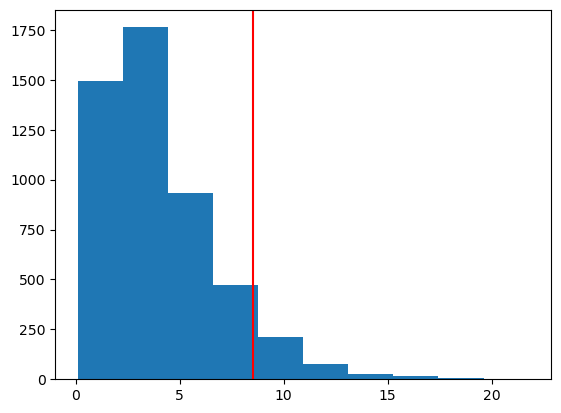

p-value is p = 0.074


In [7]:
permutation_test(numIter = 5000, sides = 1)

### Question 6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

The p-value p = 0.07 is less than the chi-squared value, and so there is no evidence against the null hypothesis and we fail to reject that director gender and film genre are independent.

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

H0: director gender and annual income are independent, and mean(male income) == mean(female income).

HA: director gender and annual income are dependent, and mean(male income) != mean(female income).

### Question 2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [8]:
def diffIncome(data = D):
    male = data[(data.dirGender == "male")]
    maleInc = male["dirIncome"].mean()  # mean of dirIncomes of males
    fem = data[(data.dirGender == "female")]
    femInc = fem["dirIncome"].mean()  # mean of dirIncomes of females
    diff_income = maleInc - femInc  # difference in incomes (ave male inc - ave female inc)
    
    return diff_income   

diffIncome()

0.6390446473389164

### Question 3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test. 

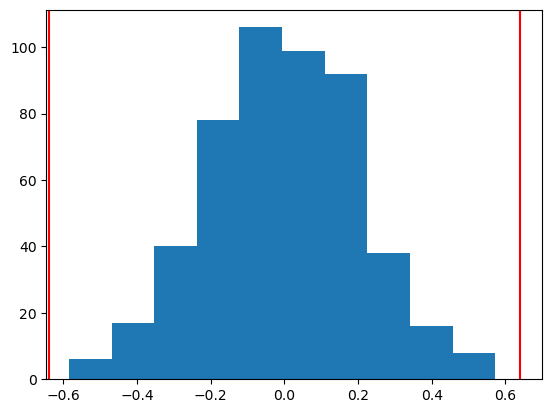

p-value is p = 0.0


In [9]:
permutation_test(fcn = diffIncome, sides = 2)

### Question 4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  


The p-value p = 0.0 indicates evidence against the null hypothesis and we reject it to conclude that director gender and salary are dependent and are not equal. Nothing can be concluded about the claim that there is gender discrimination in the American film industry without further analysis, even if these results suggest it is prevalent.

# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).
### Question 1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

In [10]:
def monteCarloSim(H0prob, N, numIter):
    # create empty array
    numHeads = np.array(range(numIter), dtype= "float64")
    
    for i in range(numIter):
        # randomly generate 0 or 1, N times
        toss = np.random.choice([0, 1], N, [1 - H0prob, H0prob])
        numHeads[i] = toss.sum()   # counts how many there are 
    return numHeads
    
# a = monteCarloSim(H0prob = 0.1, N = 62, numIter = 1000)
# a

# Answers
# def monteCarloSim(p,N,numIter):
#     # does the montecarlo simulation 
#     # Inputs:
#     # p : probability of success
#     # N : number of coin tosses
#     # numIter: number of iteration
#     # Outputs:
#     # numHeads: distribution for the number of heads
    
#     numHeads = np.array(range(numIter),dtype = 'float64')  # initialize array

#     for i in range(numIter):
#         options = [0,1] # possible outcomes
#         probDist = [1-p,p] # the probability associated for each possible outcome
        
#         # Solution 1: use random choice and sum over hits 
#         a=np.random.choice(options,N,p=probDist)
#         numHeads[i]=a.sum()  # counts how many times you get heads
#         # Solution 2: Use random binomial 
#         # numHeads[i]=np.random.binomial(N,p) 
#     return numHeads

### Question 2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim (Question 1) to simulate 2000 trials of a N coin tosses. 
The function should take as input arguments: 

* `H0prob`: The probability of heads under the Null hypothesis
* `N`: The number of coin throws per trial 
* `numHeads`: The number of observed coin tosses.  

After getting the simulation result from `monteCarloSim`, the function should plot a histogram of the recorded number of heads, and mark the real measured number (`numHeads`) with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads.  

Use the function to evaluate the medical advisor example from the lecture: Determine the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

In [13]:
def monteCarloTest(H0prob, N, numHeads):
    # simulate 2000 trials into monteCarloSim
    sim = monteCarloSim(H0prob, N, numIter = 2000)
    
    # plot histogram
    plt.hist(sim)
    plt.axvline(x = numHeads, color = "r")
    p = sum(sim <= numHeads)/len(sim)
    
    # print probability
    print("probability of heads is", p)
    return p

probability of heads is 0.0


0.0

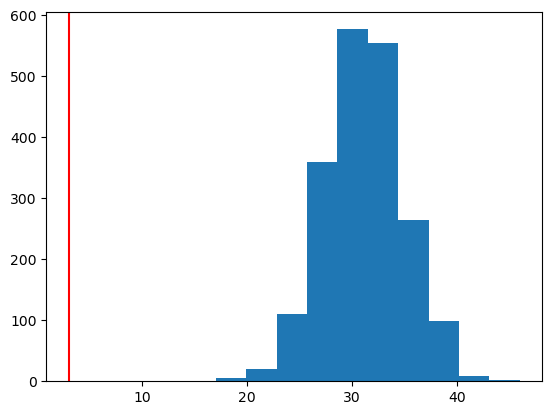

In [12]:
monteCarloTest(H0prob = 0.1, N = 62, numHeads = 3)

### Question 3: Conclusion (5pts)
Written answer: What do you conclude about the claim that the work of advisor R is lowering complication rates?

The p-value p = 0.0 indicates the probability that 3 or less complications occur for 62 subjects based on the population rate of 10%. Probability is 0.0%, meaning the population rate of 10% is not ever lower than the measured rate (3/62). We reject the null hypothesis based on these results. This is evidence that advisor R's practices are lowering the complication rate to less than the population average, and they should be hired.